# Gather

## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import chi2
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data 

In [3]:
original_data = pd.read_csv('green_tripdata_2016-02.csv')
clean_data = pd.read_csv('green_taxi_clean.csv')
df = clean_data.copy()

# Data Preparation

- convert time columns from object to datetime type

In [4]:
df['pickup_time'] = pd.to_datetime(df['pickup_time'])
df['dropoff_time'] = pd.to_datetime(df['dropoff_time'])

- create training and testing sets, training will be the first 12 days till 10:00 a.m., while the test set would 12 hours from this time.

In [5]:
train = df[df['pickup_time'] < '2016-02-12 10:00:00']
test = df[(df['pickup_time'] > '2016-02-12 10:00:00') & (df['pickup_time'] <= '2016-02-12 22:00:00')]

- create number of trips for every hour column (label)

In [6]:
train_time = train.groupby(['day_of_month', 'hour']).hour.count()
train_time = train_time.reset_index(name='pickups')

test_time = test.groupby(['day_of_month', 'hour']).hour.count()
test_time = test_time.reset_index(name='pickups')

In [7]:
train_time.sample(2)

,day_of_month,hour,pickups
162,7,18,3765
107,5,11,1941


In [8]:
test_time.sample(2)

,day_of_month,hour,pickups
1,12,11,2170
0,12,10,2302


- fix day of month to be date

In [9]:
train_time['day_of_month'] = train_time['day_of_month'].apply(lambda x: '2016-02-0' + str(x) if (x < 10)
                                                              else '2016-02-' + str(x))
test_time['day_of_month'] = test_time['day_of_month'].apply(lambda x: '2016-02-' + str(x))

- fix hour to be time

In [10]:
train_time['hour'] = train_time['hour'].apply(lambda x: str(x) + ':00:00' if (x > 10)
                                              else '0' + str(x) + ':00:00')
test_time['hour'] = test_time['hour'].apply(lambda x: str(x) + ':00:00')

- combine date and time in one column date_time

In [11]:
train_time['date_time'] = pd.to_datetime(train_time['day_of_month'] + '\n' + train_time['hour'])
test_time['date_time'] = pd.to_datetime(test_time['day_of_month'] + '\n' + test_time['hour'])

- drop unneeded columns; day_of_month and hour

In [12]:
train_time.drop(columns=['day_of_month', 'hour'], inplace=True)
test_time.drop(columns=['day_of_month', 'hour'], inplace=True)

- set time as index

In [13]:
train_time.set_index('date_time', inplace=True)
test_time.set_index('date_time', inplace=True)

- specify frequency

In [14]:
train_time = train_time.asfreq('h')
test_time = test_time.asfreq('h')

# Time-Series Analysis

- stationarity

In [15]:
print('p-value: \t{}'.format(sts.adfuller(train_time.pickups)[1]))

p-value: 	3.376433457412623e-07


Reject the null hypothesis, the time series is in fact stationary.

- plot data

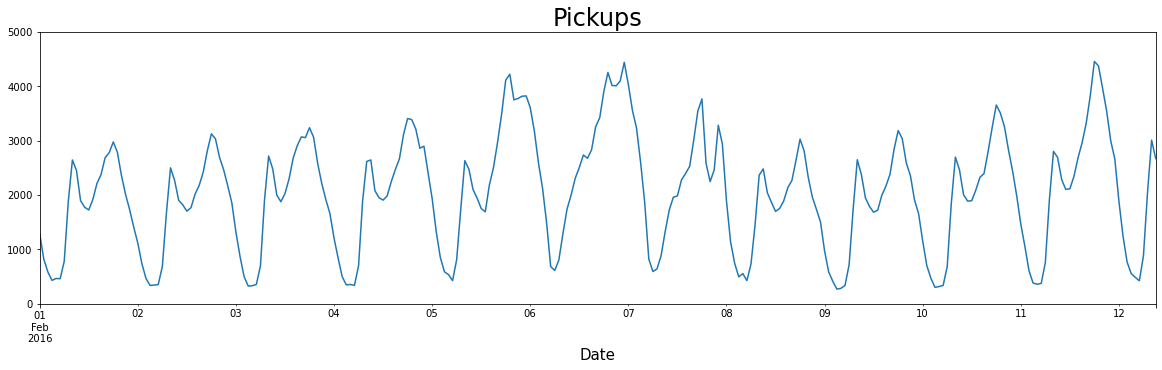

In [16]:
plt.figure(figsize=(20, 5))
train_time.pickups.plot()
plt.title('Pickups', size=24)
plt.xlabel('Date', size=15)
plt.ylim(0, 5000)
plt.show()

Seasonality & Stationary (more on that)

- Naive Decomposition

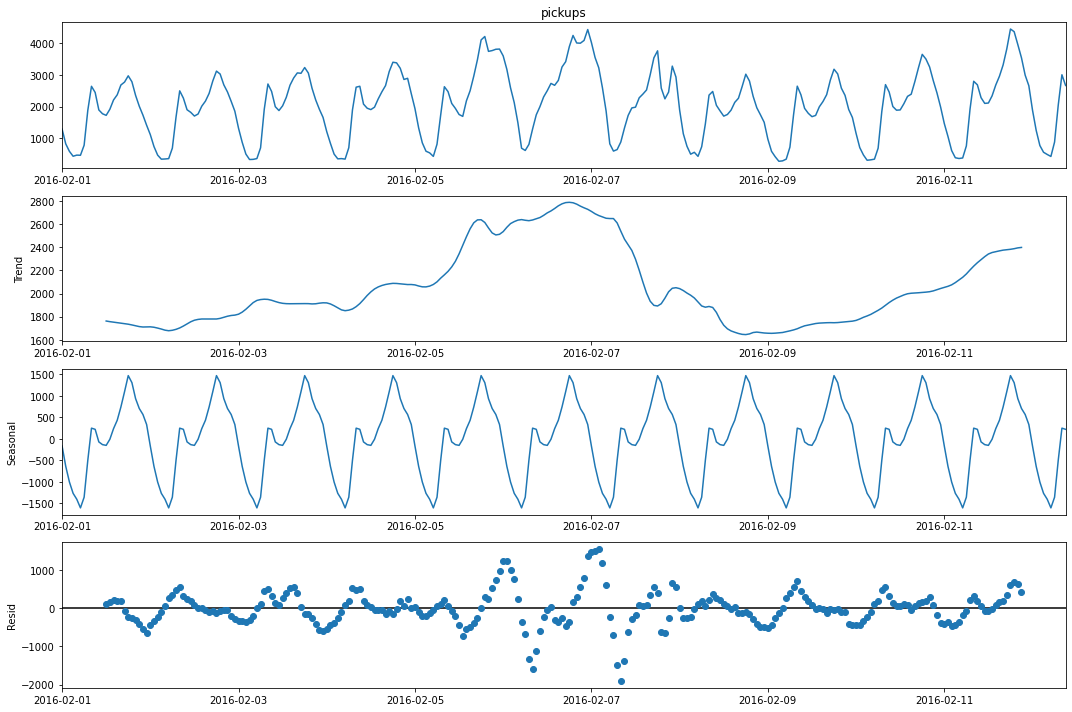

In [17]:
s_dec_additive = seasonal_decompose(train_time.pickups, model='additive')
rc('figure', figsize=(15, 10))
s_dec_additive.plot();

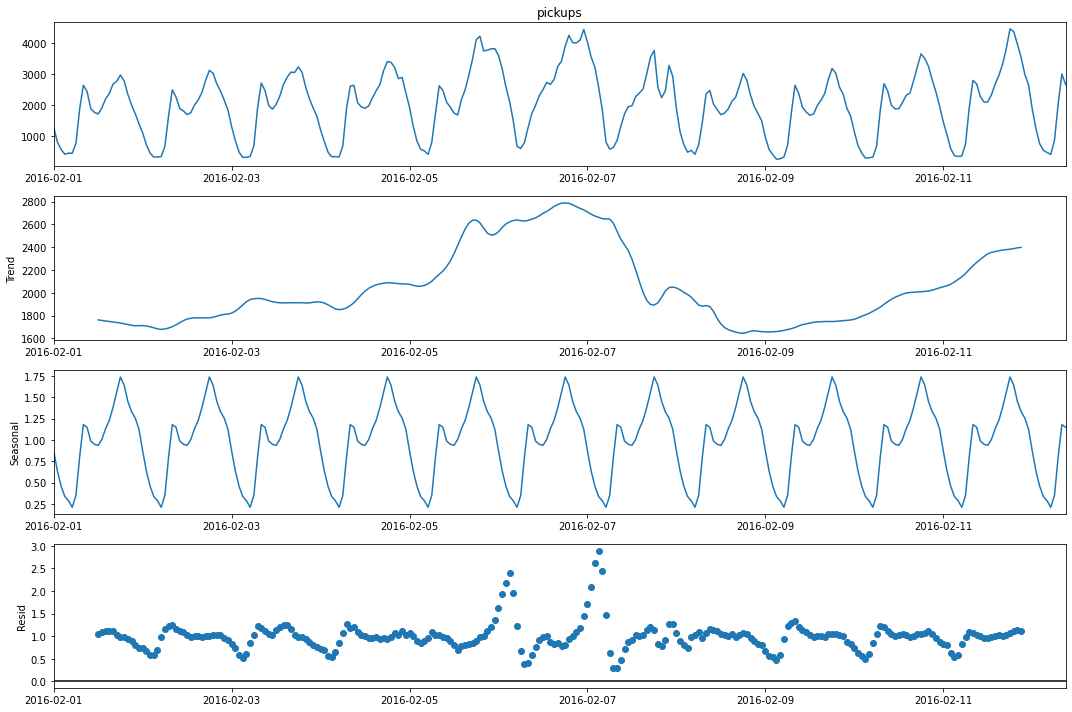

In [18]:
s_dec_multiplicative = seasonal_decompose(train_time.pickups, model='multiplicative')
rc('figure', figsize=(15, 10))
s_dec_multiplicative.plot();

- ACF

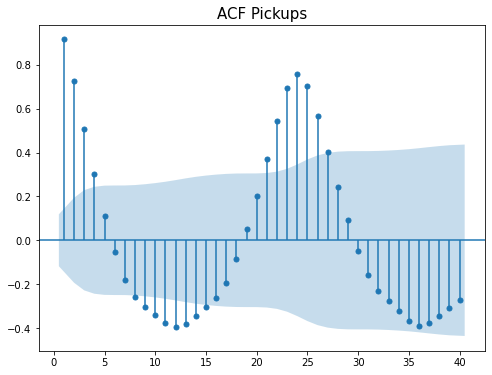

In [19]:
rc('figure', figsize=(8, 6))
sgt.plot_acf(train_time.pickups, lags=40, zero=False)
plt.title('ACF Pickups', size=15)
plt.show()

The presence of damped sine wave implies time series follows a moving average model.

- PACF

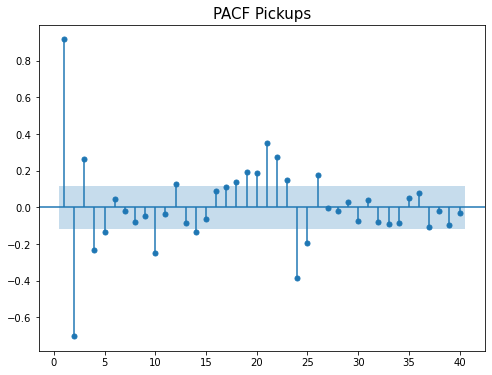

In [20]:
rc('figure', figsize=(8, 6))
sgt.plot_pacf(train_time.pickups, lags=40, zero=False, method=('ols'))
plt.title('PACF Pickups', size=15)
plt.show()

Many lags have a strong direct effect on the current value, many of them affect it negatively.

# Modeling

In [21]:
from itertools import product
p = q = range(0, 3)
d = range(0, 2)
s = 24
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in pdq]

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train_time.pickups, order=param, seasonal_order=param_seasonal,
                             enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit()
            print('SARIMA{}x{} - AIC:{} - Likelihood:{}'.format(param, param_seasonal, results.aic, results.llf))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 24) - AIC:4999.075909860219 - Likelihood:-2498.5379549301097
SARIMA(0, 0, 0)x(0, 0, 1, 24) - AIC:4293.824085840444 - Likelihood:-2144.912042920222
SARIMA(0, 0, 0)x(0, 0, 2, 24) - AIC:3751.135844561665 - Likelihood:-1872.5679222808326
SARIMA(0, 0, 0)x(0, 1, 0, 24) - AIC:3894.306247208337 - Likelihood:-1946.1531236041685
SARIMA(0, 0, 0)x(0, 1, 1, 24) - AIC:3526.953390008541 - Likelihood:-1761.4766950042706
SARIMA(0, 0, 0)x(0, 1, 2, 24) - AIC:3118.382743893606 - Likelihood:-1556.191371946803
SARIMA(0, 0, 0)x(1, 0, 0, 24) - AIC:3910.9854420342817 - Likelihood:-1953.4927210171409
SARIMA(0, 0, 0)x(1, 0, 1, 24) - AIC:3884.821111817733 - Likelihood:-1939.4105559088664
SARIMA(0, 0, 0)x(1, 0, 2, 24) - AIC:3485.242419305365 - Likelihood:-1738.6212096526824
SARIMA(0, 0, 0)x(1, 1, 0, 24) - AIC:3550.566698092734 - Likelihood:-1773.283349046367
SARIMA(0, 0, 0)x(1, 1, 2, 24) - AIC:3113.872661220706 - Likelihood:-1552.936330610353
SARIMA(0, 0, 0)x(2, 0, 0, 24) - AIC:3552.12961

select the best AIC and Log Likelihood, then optimized for a slightly higher level in terms of Auto Regressive factor (p).

In [22]:
model = SARIMAX(train_time.pickups, order=(3, 1, 2), seasonal_order=(0, 1, 2, 24),
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            pickups   No. Observations:                  274
Model:             SARIMAX(3, 1, 2)x(0, 1, 2, 24)   Log Likelihood               -1351.106
Date:                            Fri, 22 Jan 2021   AIC                           2718.211
Time:                                    19:16:52   BIC                           2744.518
Sample:                                02-01-2016   HQIC                          2728.859
                                     - 02-12-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3125      0.075     30.983      0.000       2.166       2.459
ar.L2         -1.7930      0.137    -13.110      0.000      -2.061      -1.525
ar.L3          0.4535      0.071      6.418      0.000       0.315       0.592
ma.L1         -1.9600      0.057    -34.357      0.000      -2.072      -1.848
ma.L2          0.9764      0.057     17.254      0.000       0.865       1.087
ma.S.L24      -0.6864      0.208     -3.305      0.001      -1.093      -0.279
ma.S.L48      -0.1777      0.143     -1.242      0.214      -0.458       0.103
sigma2      5.941e+04   1.16e+04      5.134      0.000    3.67e+04    8.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               387.55
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

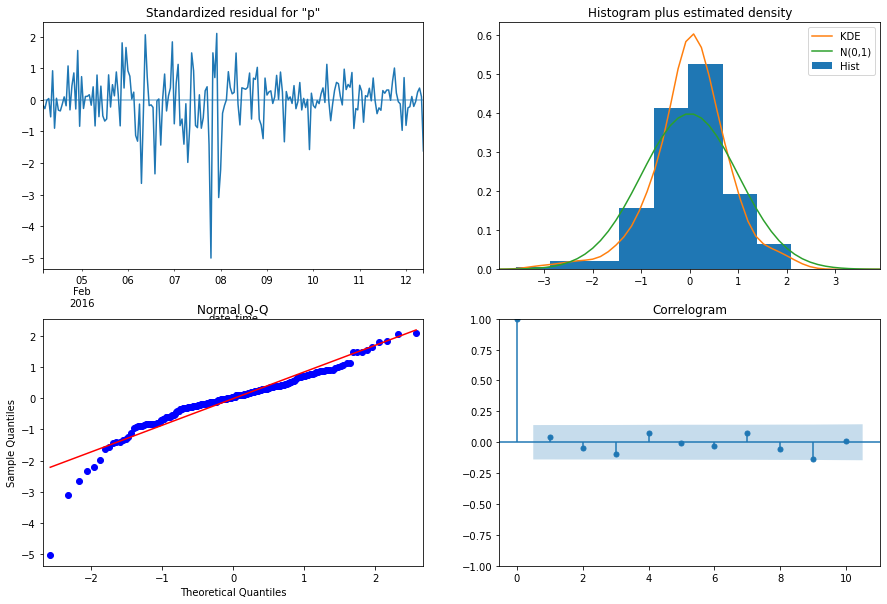

In [23]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

In [24]:
print('p-value of residuals: {}'.format(sts.adfuller(results.resid)[1]))

p-value of residuals: 0.0


There is enough evidence to reject the null hypothesis. The residuals are stationary.

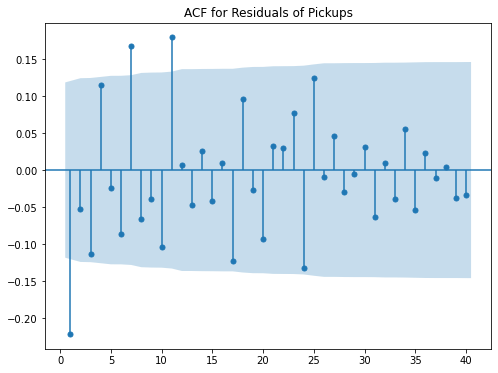

In [25]:
sgt.plot_acf(results.resid, lags=40, zero=False)
plt.title('ACF for Residuals of Pickups', size=12)
plt.show()

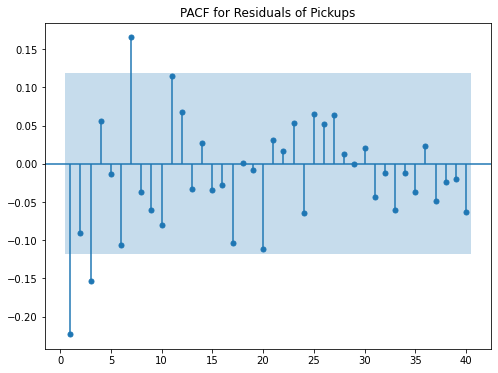

In [26]:
sgt.plot_pacf(results.resid, lags=40, zero=False, method='ols')
plt.title('PACF for Residuals of Pickups', size=12)
plt.show()

## Forecasting

In [38]:
pred = results.get_prediction(start=pd.to_datetime('2016-02-12 10:00:00'),
                              end=pd.to_datetime('2016-02-12 21:00:00'), dynamic=False)
conf_int_pred = pred.conf_int()

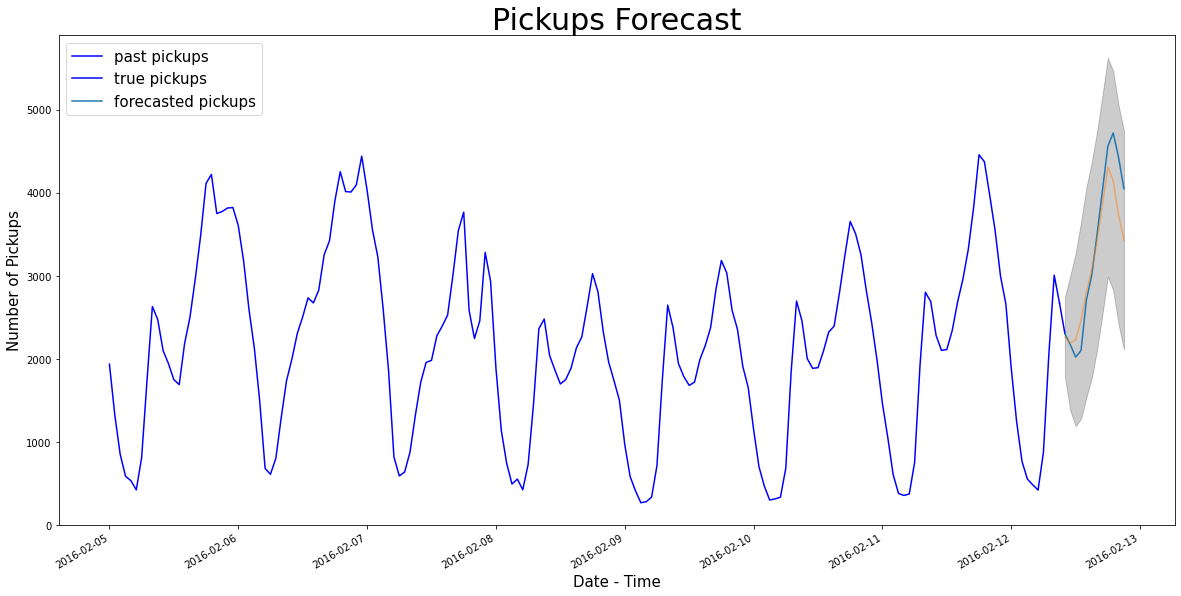

In [39]:
fig, ax = plt.subplots(figsize=(20, 10))

# connect the line between the last point in the training set and last point in the testing set
point1 = [train_time.tail(1).pickups.index[0], train_time.tail(1).pickups.values[0]]
point2 = [test_time.head(1).pickups.index[0], test_time.head(1).pickups.values[0]]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
ax.plot(x_values, y_values, color='b')

# start plotting from February, 5th to make the graph more concise
train_time['2016-02-05':].plot(ax=ax, color='b')
test_time.plot(ax=ax)
pred.predicted_mean.plot(ax=ax, alpha=0.5)
ax.fill_between(conf_int_pred.index, conf_int_pred.iloc[:, 0], conf_int_pred.iloc[:, 1], color='k', alpha=0.2)
plt.title('Pickups Forecast', size=30)
ax.set_xlabel('Date - Time', size=15)
ax.set_ylabel('Number of Pickups', size=15)
plt.legend(labels=['past pickups', 'true pickups', 'forecasted pickups'], fontsize=15, loc='upper left')
plt.show()

## Evaluation

In [40]:
y_pred = pred.predicted_mean
y_true = test_time.pickups

mse = ((y_pred - y_true) ** 2).mean()
rmse = np.sqrt(mse)

print('The selected metric to evaluate the model is Root Mean Square Error which has a value of {} pickups.'\
      .format(round(rmse, 0)))

The selected metric to evaluate the model is Root Mean Square Error which has a value of 352.0 pickups.
